## Train a model

### Get the data

In [ ]:
import numpy as np

import cv_model as cv
import tensorflow as tf

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [ ]:
# get keras model
# the function preprocess_input is keras model dependent, so this is abstracted in a function so all the correct information can be produced at once
base_model, model_name, preprocess_input = cv.get_keras_model()

In [ ]:

# label mapping maps the numerically encoded label e.g. 1 back to the label e.g.'butter_naan'
mapping_dct = cv.get_label_mapping()

# get the fully split data that has been processed by the model specific preprocess_input function
X_train, y_train, X_test, y_test, X_val, y_val, label_encoder = cv.get_split_data(preprocess_input)

### Train the model

In [ ]:
# get number of classes to use as training target
num_classes = len(mapping_dct.values())

# the tasty_model uses transfer learning on the keras model and adds some layers for our use case
tasty_model = cv.get_tasty_model(base_model, num_classes)

# set the optimizer, learning rate, loss, and target metrics
tasty_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# training params
batch_size = 32
epochs = 20
spe = len(X_train) // batch_size    
verbose = 1

# Augment the training data with a generaator.
# This improves performance with a small amount of data while reducing chance of overfitting due to the model not seeing the exact same image twice.
data_gen = ImageDataGenerator(rotation_range=30, zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15, horizontal_flip=True, fill_mode="nearest")
flow = data_gen.flow(X_train, y_train, batch_size=batch_size)

# train
history = tasty_model.fit(flow, validation_data=(X_val, y_val), epochs=epochs, steps_per_epoch=spe, verbose=verbose)

# Evaluate model
val_loss, val_accuracy = tasty_model.evaluate(X_val, y_val)
print(f'Validation accuracy: {val_accuracy * 100:.2f}%')

NameError: name 'mapping_dct' is not defined

: 

#### Visualize Training Progress

In [ ]:
def plot_history(history):
    # Plotting training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()    
    
plot_history(history)

#### Persist trained model

In [ ]:
#keras_model_path = 'models/efficientnet_v2_20_84.64.keras', 
#tflite_path='models/lite/efficientnet_v2_20_84.64.tflite', 
#weights_path = 'models/weights/efficientnet_v2_20_84.64.hdf5', 

# fake paths for testing...  delete before submitting
keras_model_path = 'models/efficientnet_v2_20_84.64_test.keras', 
tflite_path='models/lite/efficientnet_v2_20_84.64_test.tflite', 
weights_path = 'models/weights/efficientnet_v2_20_84.64_test.hdf5', 


Approach 1: Save whole model

In [ ]:
# save full keras model
tasty_model.save(keras_model_path)

Approach 2: Save weights

In [ ]:
# save model weights
tasty_model.save_weights(weights_path)

Approach 3: Convert to tflite and save that

In [ ]:
# prepare converter
converter = tf.lite.TFLiteConverter.from_keras_model(tasty_model) 

# life saving option found on stackoverflow
# https://stackoverflow.com/questions/69888228/converting-a-keras-model-to-tensorflow-lite-how-to-avoid-unsupported-operation
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]

# perform conversion
tflite_model = converter.convert()

# save
with open(tflite_path, 'wb') as f:     
  f.write(tflite_model)

## Results

This section is independent of training and evaluates results against persisted models.

In [1]:
import numpy as np

import cv_model as cv
import cv_predict as cvp

import keras
import tensorflow as tf

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [2]:
# get keras model
# the function preprocess_input is keras model dependent, so this is abstracted in a function so all the correct information can be produced at once
preprocess_input = cv.get_keras_preprocessing()

In [3]:
# get data
X_train, y_train, X_test, y_test, X_val, y_val, label_encoder = cv.get_split_data(preprocess_input)

# get model
# we will only evalute against the tflite model as that's what we're going to use in the end
pred_model = cvp.TastyFoodPredictor(preprocess_input_fn=preprocess_input, use_keras=False, use_tflite=True)

Use **X_test** and **y_test** for model evaluation.  Since these datasets were not used during training, it should give us some insight into model generalizability.

In [ ]:
# get predictions
y_pred = pred_model.predict_batch(X_test)
y_true = y_test

# since this is a multi-class target, use np.argmax to get the top choice for each row
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

#### Confusion Matrix

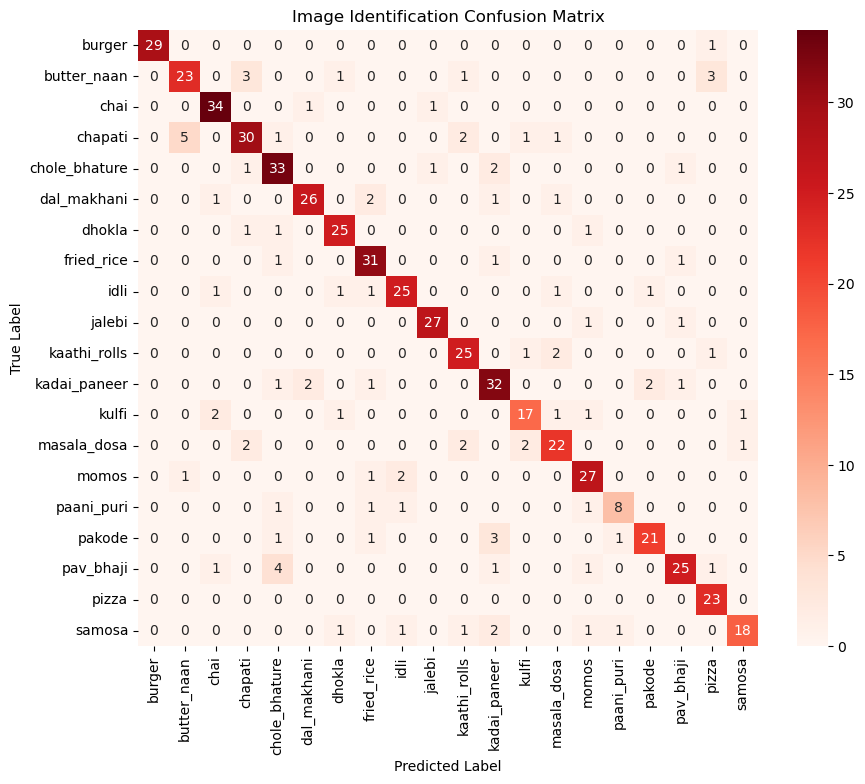

In [22]:
# convert to readible labels
labels = label_encoder.inverse_transform(range(0,20))

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds',  xticklabels=labels, yticklabels=labels)
plt.title('Image Identification Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

#### Precision and Recall

##### Class distribution

The barplot is an interesting place to start.  It would be interesting to combine the idea of how many examples there were, vs precision.

<Axes: >

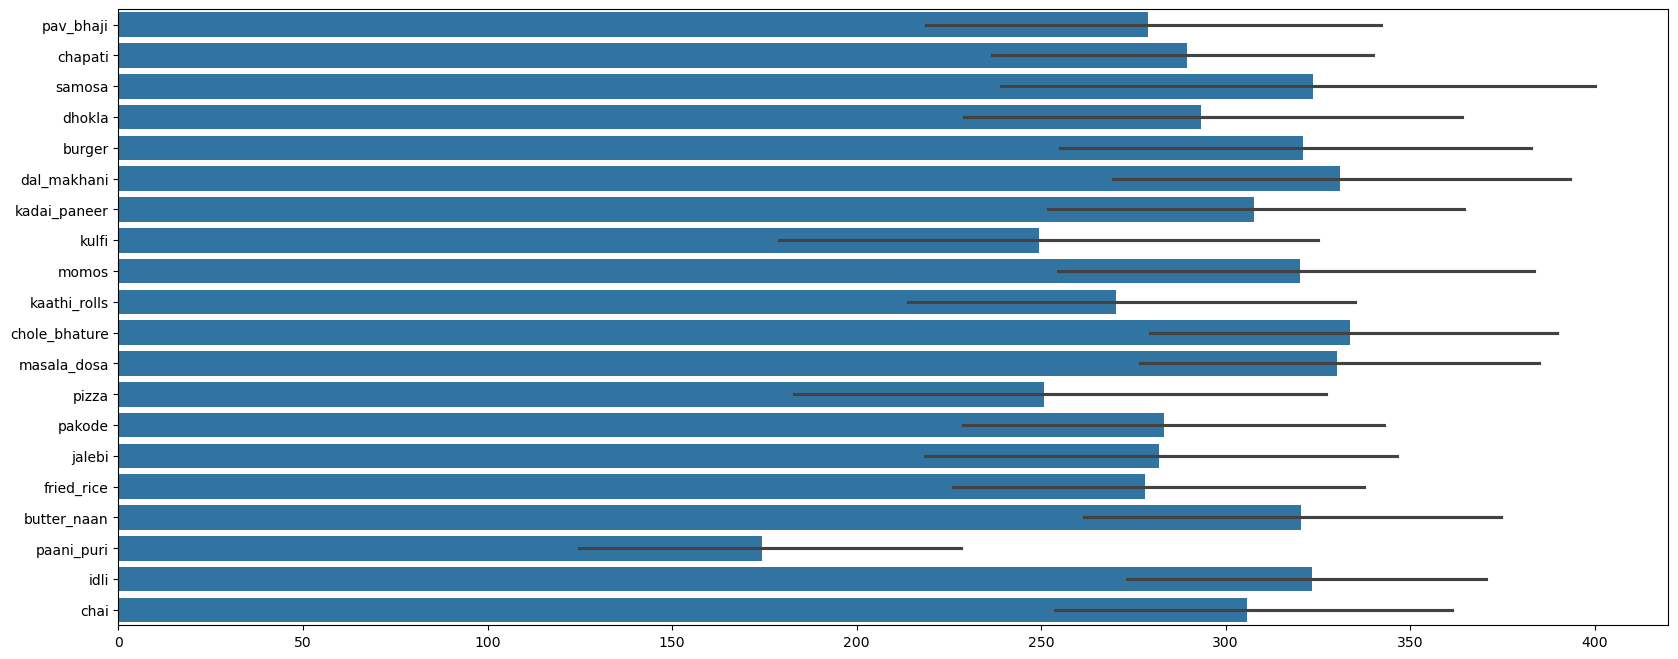

In [ ]:
# convert to readible labels
#y_true_classes = np.argmax(y_true, axis=1)
labels_freq = label_encoder.inverse_transform(y_true_classes)

plt.figure(figsize=(20, 8))
sns.barplot(labels_freq)

##### Macro Averaging

In [24]:
from sklearn.metrics import precision_recall_fscore_support



In [ ]:
target_names  = label_encoder.inverse_transform(range(0,20))
labels

array(['burger', 'butter_naan', 'chai', 'chapati', 'chole_bhature',
       'dal_makhani', 'dhokla', 'fried_rice', 'idli', 'jalebi',
       'kaathi_rolls', 'kadai_paneer', 'kulfi', 'masala_dosa', 'momos',
       'paani_puri', 'pakode', 'pav_bhaji', 'pizza', 'samosa'],
      dtype='<U13')

In [ ]:
#y_pred_classes = np.argmax(y_pred, axis=1)
#y_true_classes = np.argmax(y_true, axis=1)

precision_recall_fscore_support(y_true_classes, y_pred_classes, average='micro')


(0.8411306652491455, 0.8326243922143997, 0.8343807834452959, None)

In [60]:
from sklearn.metrics import classification_report

target_names  = label_encoder.inverse_transform(range(0,20))
target_names = [name.replace('_', ' ').title() for name in target_names]

print(classification_report(y_true_classes, y_pred_classes, target_names=target_names))

               precision    recall  f1-score   support

       Burger       1.00      0.97      0.98        30
  Butter Naan       0.79      0.74      0.77        31
         Chai       0.87      0.94      0.91        36
      Chapati       0.81      0.75      0.78        40
Chole Bhature       0.77      0.87      0.81        38
  Dal Makhani       0.90      0.84      0.87        31
       Dhokla       0.86      0.89      0.88        28
   Fried Rice       0.82      0.91      0.86        34
         Idli       0.86      0.83      0.85        30
       Jalebi       0.93      0.93      0.93        29
 Kaathi Rolls       0.81      0.86      0.83        29
 Kadai Paneer       0.76      0.82      0.79        39
        Kulfi       0.81      0.74      0.77        23
  Masala Dosa       0.79      0.76      0.77        29
        Momos       0.82      0.87      0.84        31
   Paani Puri       0.80      0.67      0.73        12
       Pakode       0.88      0.78      0.82        27
    Pav B

In [61]:
import pandas as pd
report = classification_report(y_true_classes, y_pred_classes, target_names=target_names, output_dict=True)
df_all = pd.DataFrame(report).T

# split
df_dishes = df_all[df_all.index.isin(target_names)]
df_metric = df_all[~df_all.index.isin(target_names)]
df_metric

,precision,recall,f1-score,support
accuracy,0.837793,0.837793,0.837793,0.837793
macro avg,0.841131,0.832624,0.834381,598.000000
weighted avg,0.840101,0.837793,0.836752,598.000000


In [62]:
df_dishes = df_dishes.sort_values(by='f1-score', ascending=False)
df_dishes

,precision,recall,f1-score,support
Burger,1.000000,0.966667,0.983051,30.0
Jalebi,0.931034,0.931034,0.931034,29.0
Chai,0.871795,0.944444,0.906667,36.0
Pizza,0.793103,1.000000,0.884615,23.0
Dhokla,0.862069,0.892857,0.877193,28.0
Dal Makhani,0.896552,0.838710,0.866667,31.0
Fried Rice,0.815789,0.911765,0.861111,34.0
Idli,0.862069,0.833333,0.847458,30.0
Momos,0.818182,0.870968,0.843750,31.0
Kaathi Rolls,0.806452,0.862069,0.833333,29.0


We see that *Paani Puri* and *Butter Naan* had some of the lowest F1 scores.  Also note that *Paani Puri* had low support so this could be a not-enough-data  issue.

Let's look at a confusion matrix to see if any of the low F1 labels were commonly mistaken for something else. 

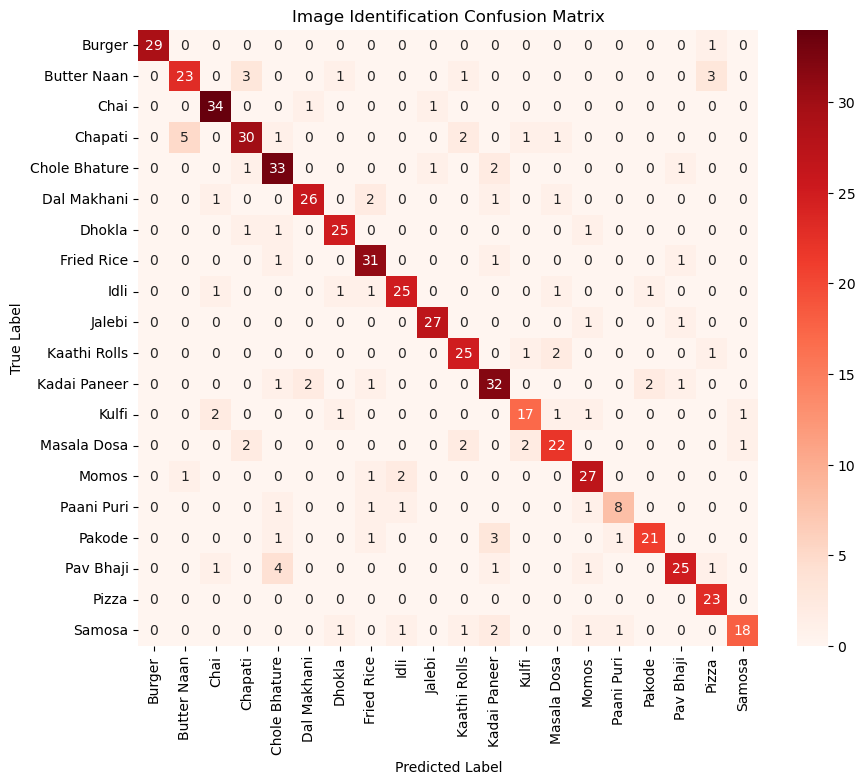

In [131]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds',  xticklabels=target_names, yticklabels=target_names)
plt.title('Image Identification Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Unsurprisingly, *Paani Puri*  was confused for many things, possibly due to lack of support.

*Butter Naan* (one of our other bottom F1 scorers) was commonly confused with two different dishes.  Let's look at the images to compare.

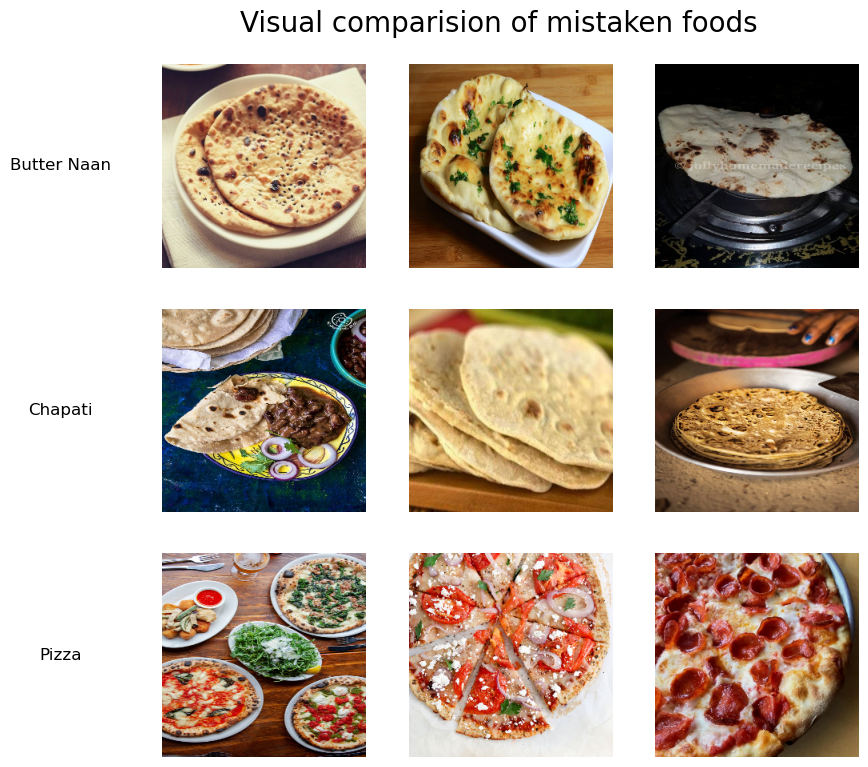

In [129]:
from os import listdir
import random
import cv2

def get_image_paths(food_name, num_images=3):
    path = f'data/Food_Classification/{food_name}/'
    files = listdir(path)
    return [f'{path}{file}' for file in random.choices(files, k=num_images)] 
    

def compare_images(base_food_name, comparison_food_list, num_images_per_food=3):

    def covert_to_pathname(name):
        return name.replace(' ', '_').lower()
    
    
    all_foods = [base_food_name] + comparison_food_list
    
    # Create subplots
    nrows = len(comparison_food_list) + 1
    fig, axes = plt.subplots(nrows=nrows, ncols=num_images_per_food, figsize=(9, 3*nrows))
    fig.suptitle('Visual comparision of mistaken foods', fontsize=20, y=0.94, verticalalignment="top")
    
    for i, food_name in enumerate(all_foods):
        
        food_folder = covert_to_pathname(food_name)
        food_image_paths = get_image_paths(food_folder, num_images_per_food)        
        
        for j, food_image_path in enumerate(food_image_paths):    
            image = cv2.cvtColor(cv2.imread(food_image_path), cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (255, 255))
            
            ax = axes[i, j]        
            ax.imshow(image)
            ax.axis('off')
            
            # only show title for first column
            if j==0:
                ax.text(-0.5, 0.5, food_name, transform=ax.transAxes, va='center', ha='center', fontsize=12)
    
    
compare_images('Butter Naan', ['Chapati','Pizza'])

In [81]:
get_x_image_paths('pizza')

['data/Food_Classification/pizza/118.jpg',
 'data/Food_Classification/pizza/146.jpg',
 'data/Food_Classification/pizza/244.jpg']

In [91]:
y = [1,2]
x = 2

[x] + y

[2, 1, 2]

##### Micro Averaging